In [759]:
import pandas as pd

In [760]:
planning = pd.read_excel('../dataset/a6_booster_delivery_planning.xlsx')
tracks = pd.read_excel('../dataset/ariane_tracks_booster_container_1.0.xlsx')

In [761]:
tracks.head(40)

,Container,Zone,Entry,Exit
0,SN7,A,09.12.2020,24.12.2020
1,SN7,B,24.12.2020,29.12.2020
2,SN7,C,29.12.2020,30.12.2020
3,SN7,D,10.01.2021,12.01.2021
4,SN7,E,12.01.2021,27.01.2021
5,SN7,D,27.01.2021,29.01.2021
6,SN7,C,08.02.2021,09.02.2021
7,SN7,B,09.02.2021,14.02.2021
8,SN3,A,09.12.2020,24.12.2020
9,SN3,B,24.12.2020,29.12.2020


In [400]:
planning = pd.read_excel('../dataset/a6_booster_delivery_planning.xlsx')
tracks = pd.read_excel('../dataset/ariane_tracks_booster_container_1.0.xlsx')

tracks['Entry'] = pd.to_datetime(tracks['Entry'], format='%d.%m.%Y')
tracks['Exit'] = pd.to_datetime(tracks['Exit'], format='%d.%m.%Y')

sorted_tracks = tracks.sort_values(by=['Container','Entry'])

In [401]:
sorted_tracks = tracks.sort_values(by=['Container','Entry'])

In [544]:
sorted_tracks['StayDays'].max()

Timedelta('15 days 00:00:00')

In [546]:
sorted_tracks.head(50)

,Container,Zone,Entry,Exit,StayDays
0,SN1,A,2021-09-15,2021-09-30,15 days
1,SN1,B,2021-09-30,2021-10-05,5 days
2,SN1,C,2021-10-05,2021-10-06,1 days
3,SN1,D,2021-10-17,2021-10-19,2 days
4,SN1,E,2021-10-19,2021-11-03,15 days
5,SN1,D,2021-11-03,2021-11-05,2 days
6,SN1,C,2021-11-16,2021-11-17,1 days
7,SN1,B,2021-11-17,2021-11-22,5 days
8,SN1,A,2022-09-26,2022-10-11,15 days
9,SN1,B,2022-10-11,2022-10-16,5 days


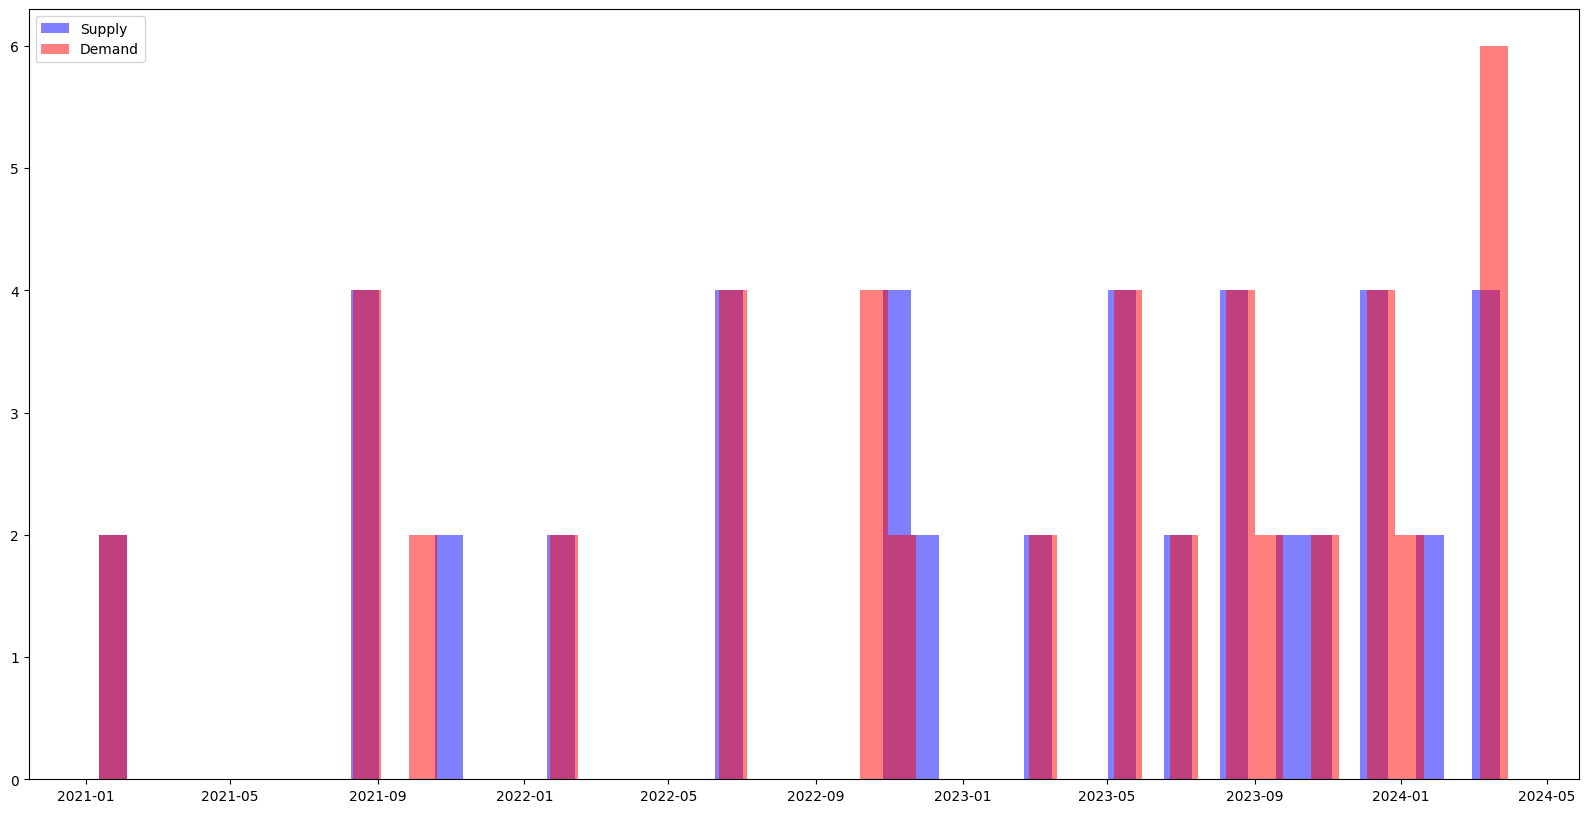

In [118]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.hist(sorted_tracks[sorted_tracks['Zone'] == 'E']['Entry'], ls='dashed', bins=50, fc=(0, 0, 1, 0.5),label='Supply')
hist2 = ax.hist(planning[planning['Date'] <= '2024-04-25']['Date'], weights=planning[planning['Date'] <= '2024-04-25']['Config'], ls='dotted', bins=50, fc=(1, 0, 0, 0.5), label='Demand')
ax.legend(prop={'size': 10})
plt.show()

In [132]:
grouped_tracks = sorted_tracks.groupby(['Zone', 'Entry'], as_index=False).count()

In [139]:
real_world = grouped_tracks[(grouped_tracks['Zone'] == 'E')][['Entry', 'Container']]

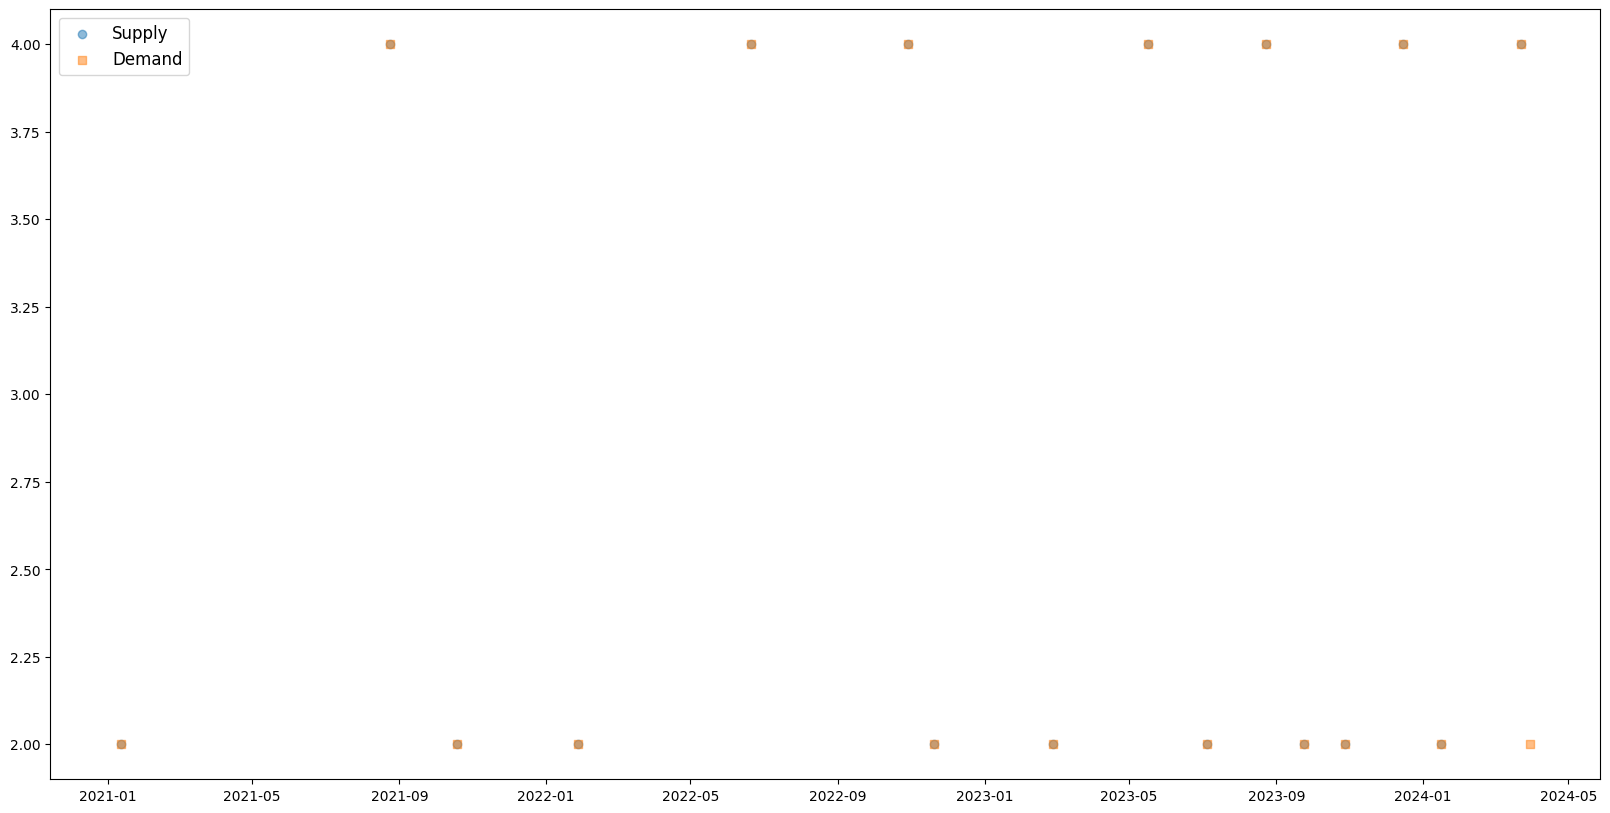

In [163]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.scatter(real_world['Entry'], real_world['Container'], marker='o', label='Supply', alpha=0.5)
plt.scatter(planning[planning['Date'] <= '2024-04-25']['Date'], planning[planning['Date'] <= '2024-04-25']['Config'], marker='s', label='Demand', alpha=0.5)
ax.legend(prop={'size': 12})

In [172]:
all(planning[planning['Date'] < '2024-03-30'] == real_world.rename(columns={'Container': 'Config', 'Entry': 'Date'}).reset_index(drop=True))   

True

(array([ 2.,  8.,  4., 12., 14., 12., 16., 14., 16., 22.]),
 array([18639. , 18855.2, 19071.4, 19287.6, 19503.8, 19720. , 19936.2,
        20152.4, 20368.6, 20584.8, 20801. ]),
 <BarContainer object of 10 artists>)

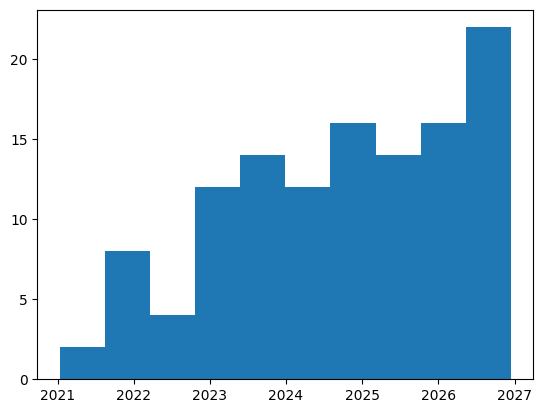

In [54]:
plt.hist(planning['Date'], weights=planning['Config'])

## Architecture

In [768]:
import pandas as pd
import numpy as np
import torch

In [773]:
planning = pd.read_excel('../dataset/a6_booster_delivery_planning.xlsx')
tracks = pd.read_excel('../dataset/ariane_tracks_booster_container_1.0.xlsx')

tracks['Entry'] = pd.to_datetime(tracks['Entry'], format='%d.%m.%Y')
tracks['Exit'] = pd.to_datetime(tracks['Exit'], format='%d.%m.%Y')

sorted_tracks = tracks.sort_values(by=['Container','Entry'])

sorted_tracks = sorted_tracks.reset_index(drop=True)
sorted_tracks['StayDays'] = sorted_tracks['Exit'] - sorted_tracks['Entry']

In [774]:
sorted_tracks.head(50)

,Container,Zone,Entry,Exit,StayDays
0,SN1,A,2021-09-15,2021-09-30,15 days
1,SN1,B,2021-09-30,2021-10-05,5 days
2,SN1,C,2021-10-05,2021-10-06,1 days
3,SN1,D,2021-10-17,2021-10-19,2 days
4,SN1,E,2021-10-19,2021-11-03,15 days
5,SN1,D,2021-11-03,2021-11-05,2 days
6,SN1,C,2021-11-16,2021-11-17,1 days
7,SN1,B,2021-11-17,2021-11-22,5 days
8,SN1,A,2022-09-26,2022-10-11,15 days
9,SN1,B,2022-10-11,2022-10-16,5 days


In [876]:
sample = sorted_tracks[sorted_tracks['Container'] == 'SN4']

In [806]:
samp['ZonePos'] = [ord(x) - 64 for x in samp['Zone']]
samp['ZonePosPrev'] = [np.nan] + [ord(x) - 64 for x in samp['Zone']][:-1]
samp['ZoneDelta'] = samp['ZonePos'] - samp['ZonePosPrev']
samp.loc[samp['ZoneDelta'] >= 0, 'Zone'] = samp[samp['ZoneDelta'] >= 0]['Zone'].astype(str) + '1'

/var/folders/g0/m852bq5j7gd84y0trm3pm2yr0000gn/T/ipykernel_69811/3867376298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp['ZoneDelta'] = samp['ZonePos'] - samp['ZonePosPrev']


In [879]:
def stay_prep(sample):

    sample = sample.reset_index(drop=True)

    sample['ZonePos'] = [ord(x) - 64 for x in sample['Zone']]
    sample['ZonePosPrev'] = [np.nan] + [ord(x) - 64 for x in sample['Zone']][:-1]
    sample['ZoneDelta'] = sample['ZonePos'] - sample['ZonePosPrev']
    sample.loc[sample['ZoneDelta'] < 0, 'Zone'] = sample[sample['ZoneDelta'] < 0]['Zone'].astype(str) + '1'

    df_staying = pd.get_dummies(sample['Zone'])
    df_staying['Container'] = sample['Container']
    df_staying['Entry'] = sample['Entry']
    df_staying['Exit'] = sample['Exit']
    df_staying['Days'] = sample['StayDays']

    return df_staying

def move_prep(sample):

    sample = sample.reset_index(drop=True)

    sample['Transition'] = sample['Zone'].shift(1).str.cat(sample['Zone'])
    df_moving = pd.get_dummies(sample['Transition'])

    exit_shift = sample['Exit'][:-1].reset_index(drop=True)
    exit_shift.index = np.arange(1, len(exit_shift) + 1)
    df_moving.loc[1:, 'Entry'] = exit_shift
    df_moving.loc[1:,'Exit'] = sample[1:]['Entry']
    
    shift = sample[1:]['Entry'].reset_index(drop=True) - sample['Exit'][:-1]
    shift.index = np.arange(1, len(shift) + 1)
    sample.loc[1:, 'TransitionTime'] = shift
    df_moving['Container'] = sample['Container']
    df_moving['Days'] = sample['TransitionTime']
    print('Length before:', len(df_moving))
    df_moving = df_moving.dropna(subset='Days')
    print('Length after:', len(df_moving))

    return df_moving
        

In [880]:
def data_prep(sorted_tracks):
    out = None

    for container in sorted_tracks['Container'].unique():
        print('Doing ', container)
        cont_df = sorted_tracks[sorted_tracks['Container'] == container]
        moving = move_prep(cont_df)
        staying = stay_prep(cont_df)

        if out is None:
            out = pd.concat([moving, staying])
        else:
            out = pd.concat([out, moving, staying])

    return out

In [963]:
out = data_prep(sorted_tracks)

Doing  SN1
Length before: 40
Length after: 39
Doing  SN2
Length before: 40
Length after: 39
Doing  SN3
Length before: 39
Length after: 38
Doing  SN4
Length before: 40
Length after: 39
Doing  SN5
Length before: 17
Length after: 16
Doing  SN6
Length before: 56
Length after: 55
Doing  SN7
Length before: 72
Length after: 71
Doing  SN8
Length before: 64
Length after: 63


#### CA is above because of the errors in the data; should add a preprocessing

In [964]:
# so far - just drop it
out = out.drop(columns=['CA'])
# set NaN to 0:
out = out.fillna(False)

In [965]:
out

,AB,BA,BC,CB,CD,DC,DE,ED,Entry,Exit,...,Days,A,A1,B,B1,C,C1,D,D1,E
1,True,False,False,False,False,False,False,False,2021-09-30,2021-09-30,...,0 days,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,2021-10-05,2021-10-05,...,0 days,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,2021-10-06,2021-10-17,...,11 days,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,2021-10-19,2021-10-19,...,0 days,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,True,2021-11-03,2021-11-03,...,0 days,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,False,False,False,False,False,False,False,False,2024-03-21,2024-03-23,...,2 days,False,False,False,False,False,False,True,False,False
60,False,False,False,False,False,False,False,False,2024-03-23,2024-04-07,...,15 days,False,False,False,False,False,False,False,False,True
61,False,False,False,False,False,False,False,False,2024-04-07,2024-04-09,...,2 days,False,False,False,False,False,False,False,True,False
62,False,False,False,False,False,False,False,False,2024-04-19,2024-04-20,...,1 days,False,False,False,False,False,True,False,False,False


In [966]:
out[['A', 'AB', 'B', 'B1', 'BC', 'C', 'C1', 'CD', 'D', 'D1', 'DE', 'E', 'ED', 'DC', 'CB', 'BA']] = out[['A', 'AB', 'B', 'B1', 'BC', 'C', 'C1', 'CD', 'D', 'D1', 'DE', 'E', 'ED', 'DC', 'CB', 'BA']]*1
out = out[['Container', 'A', 'AB', 'B', 'B1', 'BC', 'C', 'C1', 'CD', 'D', 'D1', 'DE', 'E', 'ED', 'DC', 'CB', 'BA', 'Entry', 'Exit', 'Days']]

In [967]:
out

,Container,A,AB,B,B1,BC,C,C1,CD,D,D1,DE,E,ED,DC,CB,BA,Entry,Exit,Days
1,SN1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-09-30,2021-09-30,0 days
2,SN1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2021-10-05,2021-10-05,0 days
3,SN1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2021-10-06,2021-10-17,11 days
4,SN1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2021-10-19,2021-10-19,0 days
5,SN1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2021-11-03,2021-11-03,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,SN8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2024-03-21,2024-03-23,2 days
60,SN8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2024-03-23,2024-04-07,15 days
61,SN8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2024-04-07,2024-04-09,2 days
62,SN8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2024-04-19,2024-04-20,1 days


### TODO: Add sanity check for the data

In [968]:
summed_out = out.drop(columns=['Container']).groupby(['Entry', 'Exit'], as_index=False).sum()

In [969]:
summed_out

,Entry,Exit,A,AB,B,B1,BC,C,C1,CD,D,D1,DE,E,ED,DC,CB,BA,Days
0,2020-12-09,2020-12-24,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30 days
1,2020-12-24,2020-12-24,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 days
2,2020-12-24,2020-12-29,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,10 days
3,2020-12-29,2020-12-29,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0 days
4,2020-12-29,2020-12-30,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,2024-04-07,2024-04-09,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,8 days
263,2024-04-09,2024-04-19,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,40 days
264,2024-04-19,2024-04-20,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,4 days
265,2024-04-20,2024-04-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0 days


#### removing the inverted combinations (BA, CB, etc.)

In [970]:
inverted = [['BA', 'AB'], ['CB', 'BC'], ['DC', 'CD'], ['ED', 'DE']]

summed_out['Inverted'] = 0
for inv, true in inverted:
    mask = summed_out[inv] != 0
    print(len(mask))
    summed_out.loc[mask, true] = summed_out[mask][inv]
    summed_out.loc[mask, 'Inverted'] = 1

summed_out_inverted = summed_out.drop(columns=['BA', 'CB', 'DC', 'ED'])


267
267
267
267


In [971]:
summed_out_inverted = summed_out_inverted.rename(columns={'E1': 'E'})

for inv, true in [['B1', 'B'], ['C1', 'C'], ['D1', 'D']]:
    mask = summed_out_inverted[inv] != 0
    print(len(mask))
    summed_out_inverted.loc[mask, true] = summed_out_inverted[mask][inv]
    summed_out_inverted.loc[mask, 'Inverted'] = 1

summed_out_inverted = summed_out_inverted.drop(columns=['B1', 'C1', 'D1'])

267
267
267


In [972]:
summed_out_inverted

,Entry,Exit,A,AB,B,BC,C,CD,D,DE,E,Days,Inverted
0,2020-12-09,2020-12-24,2,0,0,0,0,0,0,0,0,30 days,0
1,2020-12-24,2020-12-24,0,2,0,0,0,0,0,0,0,0 days,0
2,2020-12-24,2020-12-29,0,0,2,0,0,0,0,0,0,10 days,0
3,2020-12-29,2020-12-29,0,0,0,2,0,0,0,0,0,0 days,0
4,2020-12-29,2020-12-30,0,0,0,0,2,0,0,0,0,2 days,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,2024-04-07,2024-04-09,0,0,0,0,0,0,4,0,0,8 days,1
263,2024-04-09,2024-04-19,0,0,0,0,0,4,0,0,0,40 days,1
264,2024-04-19,2024-04-20,0,0,0,0,4,0,0,0,0,4 days,1
265,2024-04-20,2024-04-20,0,0,0,4,0,0,0,0,0,0 days,1


In [973]:
# since we summed the number of days, we need to divide it by the number of occurences
summed_out_inverted['Days'] = summed_out_inverted['Days'].dt.days
summed_out_inverted[['A', 'AB', 'B', 'BC', 'C', 'CD', 'D', 'DE', 'E']] = summed_out_inverted[['A', 'AB', 'B', 'BC', 'C', 'CD', 'D', 'DE', 'E']].astype(int)
summed_out_inverted['Days'] = summed_out_inverted['Days'] / summed_out_inverted[['A', 'AB', 'B', 'BC', 'C', 'CD', 'D', 'DE', 'E']].sum(axis=1)

In [977]:
# something weird is going on 
summed_out_inverted = summed_out_inverted[summed_out_inverted['Days'] != np.inf]
summed_out_inverted['Days'] = summed_out_inverted['Days'].astype(int)

/var/folders/g0/m852bq5j7gd84y0trm3pm2yr0000gn/T/ipykernel_69811/4123594864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summed_out_inverted['Days'] = summed_out_inverted['Days'].astype(int)


In [983]:
summed_out_inverted.head(60)

,Entry,Exit,A,AB,B,BC,C,CD,D,DE,E,Days,Inverted
0,2020-12-09,2020-12-24,2,0,0,0,0,0,0,0,0,15,0
1,2020-12-24,2020-12-24,0,2,0,0,0,0,0,0,0,0,0
2,2020-12-24,2020-12-29,0,0,2,0,0,0,0,0,0,5,0
3,2020-12-29,2020-12-29,0,0,0,2,0,0,0,0,0,0,0
4,2020-12-29,2020-12-30,0,0,0,0,2,0,0,0,0,1,0
5,2020-12-30,2021-01-10,0,0,0,0,0,2,0,0,0,11,0
6,2021-01-10,2021-01-12,0,0,0,0,0,0,2,0,0,2,0
7,2021-01-12,2021-01-12,0,0,0,0,0,0,0,2,0,0,0
8,2021-01-12,2021-01-27,0,0,0,0,0,0,0,0,2,15,0
9,2021-01-27,2021-01-27,0,0,0,0,0,0,0,2,0,0,1


In [757]:
# summed_out = summed_out.drop(columns=['Entry', 'Exit'])

### Training

In [465]:
data = (out-out.min())/(out.max()-out.min())

In [466]:
data

,A,AB,B,BC,C,CD,D,DE,E,ED,DC,CB,BA,Days
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013699
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041096
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013699
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005479
724,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013699
725,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005479
726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [467]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1
SEED = 42

# instead of stratifying by days, we shuffle:
out = out.sample(frac=1, random_state=SEED).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    out.drop(columns='Days'),
    out['Days'],
    test_size=TEST_SIZE,
    random_state=SEED
)

In [468]:
X_train

,A,AB,B,BC,C,CD,D,DE,E,ED,DC,CB,BA
78,0,0,0,0,0,0,0,0,0,0,0,1,0
393,0,0,0,0,0,0,0,0,0,0,0,0,1
199,0,0,0,0,0,0,0,1,0,0,0,0,0
541,0,0,1,0,0,0,0,0,0,0,0,0,0
299,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,0,0,0,0,1,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,1,0,0,0
270,0,0,0,0,0,0,0,0,0,1,0,0,0
435,0,0,0,0,0,0,1,0,0,0,0,0,0


In [469]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [470]:
y_pred = reg.predict(X_test)

In [471]:
y_pred

array([ 5.68434189e-14,  2.00000000e+00,  5.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  1.03095238e+01,  1.00000000e+00, -5.68434189e-14,
        2.00000000e+00,  5.68434189e-14,  2.00000000e+00,  5.68434189e-14,
        1.05128205e+01, -2.84217094e-14,  8.52651283e-14,  1.00000000e+00,
        3.12638804e-13,  1.50000000e+01,  3.12638804e-13,  2.00000000e+00,
        9.95588235e+01, -5.68434189e-14,  5.00000000e+00,  9.95588235e+01,
        3.12638804e-13,  3.12638804e-13,  8.52651283e-14,  1.05128205e+01,
       -2.84217094e-14,  1.50000000e+01,  1.05128205e+01, -5.68434189e-14,
        1.05128205e+01,  2.00000000e+00, -5.68434189e-14,  1.50000000e+01,
       -2.84217094e-14,  5.00000000e+00, -2.84217094e-14,  1.50000000e+01,
        3.12638804e-13,  1.00000000e+00, -2.84217094e-14,  2.00000000e+00,
        2.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.05128205e+01,
        9.95588235e+01,  1.03095238e+01,  5.68434189e-14,  1.03095238e+01,
        5.00000000e+00, -

In [472]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

1068.7105381423087

#### Random Forest

In [473]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=0).fit(X_train, y_train)

In [475]:
y_pred = regr.predict(X_test)
mean_squared_error(y_test, y_pred)

1076.772299960816

### CatBoost

TBD

### PCA

### UPD

In [526]:
out['Days'].unique()

array([ 12,   0,  15,   5,   2,  11,  14,   1,   9,  16,  10, 158, 231,
       308,  46,  64, 177,  30, 365, 232, 133,  87,  33,  78,  31, 163,
        90, 184,  98, 145, 234, 296, 122], dtype=int32)

In [549]:
out['Days'].iloc[0]

12

In [534]:
out[out['BA'] == 1]['Days']

14      14
27      16
65     158
66     231
69     308
107     46
110     64
123    177
124     30
172     46
201     11
213    365
223    232
243    133
246     87
281     64
282     33
295     78
336     31
344     11
393     16
406     33
409     16
454     90
465     14
492    158
501    184
521     98
536    145
554    234
564    234
620    296
638     33
644     31
672    133
674      0
705    122
709     46
Name: Days, dtype: int32

In [517]:
from sklearn.decomposition import PCA

# data = (out-out.min())/(out.max()-out.min())
data = out
pca_data = data.drop(columns='Days')
pca_y = data['Days']

In [518]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(pca_data)

In [519]:
pca_data

array([[ 3.29771430e-16,  6.05139147e-03, -2.53387324e-01],
       [-2.53318888e-15,  6.05139147e-03, -2.53387324e-01],
       [-2.63042236e-15,  6.05139147e-03, -2.53387324e-01],
       ...,
       [-1.50541653e-15,  6.18787176e-03, -2.62703758e-01],
       [-2.88168745e-15,  5.92080170e-03, -2.44709049e-01],
       [-7.07106781e-01, -4.15035864e-01,  4.01356217e-01]])

In [520]:
print(pca.explained_variance_ratio_)

[0.13850694 0.13751171 0.11170568]


In [521]:
X_train, X_test, y_train, y_test = train_test_split(
    pca_data,
    pca_y,
    test_size=TEST_SIZE,
    random_state=SEED
)

In [522]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=0).fit(X_train, y_train)

In [523]:
y_pred = regr.predict(X_test)
mean_squared_error(y_test, y_pred)

1089.0788385172336

In [524]:
y_pred

array([ 5.05448632,  2.        ,  5.        ,  2.        ,  2.        ,
        5.05448632,  1.        ,  5.05448632,  2.        ,  5.05448632,
        2.        ,  5.05448632,  5.05448632,  5.05448632,  5.05448632,
        1.        ,  0.        , 15.        ,  0.        ,  2.        ,
       99.16418128,  5.05448632,  5.        , 99.16418128,  0.        ,
        0.        ,  5.05448632,  5.05448632,  5.05448632,  5.05448632,
        5.05448632,  5.05448632,  5.05448632,  2.        ,  5.05448632,
        5.05448632,  5.05448632,  5.        ,  5.05448632, 15.        ,
        0.        ,  1.        ,  5.05448632,  2.        ,  2.        ,
        1.        ,  1.        ,  5.05448632, 99.16418128,  5.05448632,
        5.05448632,  5.05448632,  5.        ,  5.05448632,  2.        ,
       15.        ,  2.        ,  2.        ,  5.05448632,  5.05448632,
        5.05448632,  5.05448632,  0.        ,  5.05448632,  5.05448632,
       15.        ,  1.        ,  2.        , 99.16418128,  5.05

In [516]:
y_test

39     0.000000
335    0.005479
326    0.013699
512    0.005479
548    0.005479
         ...   
709    0.126027
576    0.032877
260    0.000000
23     0.041096
595    0.000000
Name: Days, Length: 73, dtype: float64